# Import Libraries and Data

In [92]:
%pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
import gc
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow    # parquet engine library
from scipy.stats import loguniform

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier, early_stopping
import lightgbm as lgb

from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
#from sklearn import metrics


sns.set_palette("Set2")

%pylab inline
%matplotlib inline

pd.set_option('expand_frame_repr', False)  
pd.set_option('display.max_rows', None) 

Populating the interactive namespace from numpy and matplotlib


In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# EDA work book processed the data

In [96]:
processed_train_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/processed_sp_train.parquet'
data_train = pd.read_parquet(processed_train_path)


In [97]:
processed_test_path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/processed_sp_test.parquet'
data_test = pd.read_parquet(processed_test_path)

# Data review

In [98]:
data_train.shape

(458913, 182)

In [99]:
data_train.set_index('customer_ID', inplace = True)
data_train.head(5)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.152932,0.525600,...,-1,-1,0,0,0.0,0.141214,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.152932,0.060646,...,-1,-1,0,0,0.0,0.141214,0,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,0,0.004284,0.812649,0.006450,0.165509,0.0,0.007196,0.152932,0.060646,...,-1,-1,0,0,0.0,0.141214,0,0.000834,0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.152932,0.046104,...,-1,-1,0,0,0.0,0.141214,0,0.005560,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,0,0.007679,0.815746,0.001247,0.176403,0.0,0.005528,0.152932,0.044671,...,-1,-1,0,0,0.0,0.141214,0,0.006944,0,0


In [100]:
data_test.shape

(924621, 181)

In [101]:
data_test.set_index('customer_ID', inplace = True)
data_test.head(5)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.568930,4,0.010779,1.009347,0.000000,0.149413,0.0,0.003576,0.103745,0.007398,...,-1,-1,-1,0,0,0.000000,0.103164,0,0.003690,0
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.841177,4,0.016562,1.009245,0.000000,0.112195,0.0,0.011386,0.103745,0.007398,...,-1,-1,-1,0,0,0.000000,0.103164,0,0.000247,0
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.697522,0,0.001484,0.810072,0.000000,0.166165,0.0,0.015938,0.103745,0.105303,...,-1,-1,-1,1,0,0.896224,0.150203,1,0.457819,1
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.513186,11,0.149511,0.205678,0.000000,0.181200,0.0,0.498516,0.103745,0.211615,...,-1,-1,-1,1,0,0.919774,0.255263,1,0.500924,2
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.254478,26,0.563603,0.038021,0.503154,0.168317,0.0,0.830857,0.103745,0.071884,...,-1,-1,-1,0,0,0.000000,0.255263,0,0.001558,0


In [102]:
cat_features =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120',  'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 
cat_features

['B_30',
 'B_38',
 'D_114',
 'D_116',
 'D_117',
 'D_120',
 'D_126',
 'D_63',
 'D_64',
 'D_66',
 'D_68']

In [103]:
for cat_col in cat_features:
  encoder =  LabelEncoder()
  data_train[cat_col] = encoder.fit_transform(data_train[cat_col])
  data_test[cat_col] = encoder.transform(data_test[cat_col])

In [104]:
data_train['B_3'].head(10)

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    0.007174
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    0.005068
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    0.007196
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    0.009937
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    0.005528
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c    0.006134
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4    0.125927
0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381    0.149496
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85    1.155846
00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e4063bdf6b0f7d51eb6    0.009862
Name: B_3, dtype: float32

In [105]:
data_train['B_30'].head(10)

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    1
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    1
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    1
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    1
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    1
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c    1
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4    1
0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381    1
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85    2
00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e4063bdf6b0f7d51eb6    1
Name: B_30, dtype: int64

In [106]:
data_train.dtypes

P_2       float32
D_39        int16
B_1       float32
B_2       float32
R_1       float32
S_3       float32
D_41      float32
B_3       float32
D_42      float32
D_43      float32
D_44         int8
B_4         int16
D_45      float32
B_5       float32
R_2          int8
D_46      float32
D_47      float32
D_48      float32
D_49        int16
B_6       float32
B_7       float32
B_8       float32
D_50      float32
D_51         int8
B_9       float32
R_3          int8
D_52      float32
P_3       float32
B_10      float32
D_53      float32
S_5       float32
B_11      float32
S_6          int8
D_54      float32
R_4          int8
S_7       float32
B_12      float32
S_8         int16
D_55      float32
D_56      float32
B_13      float32
R_5          int8
D_58      float32
S_9       float32
B_14      float32
D_59         int8
D_60      float32
D_61      float32
B_15      float32
S_11         int8
D_62      float32
D_63        int64
D_64        int64
D_65        int16
B_16         int8
B_17      

In [107]:
data_train.dtypes

P_2       float32
D_39        int16
B_1       float32
B_2       float32
R_1       float32
S_3       float32
D_41      float32
B_3       float32
D_42      float32
D_43      float32
D_44         int8
B_4         int16
D_45      float32
B_5       float32
R_2          int8
D_46      float32
D_47      float32
D_48      float32
D_49        int16
B_6       float32
B_7       float32
B_8       float32
D_50      float32
D_51         int8
B_9       float32
R_3          int8
D_52      float32
P_3       float32
B_10      float32
D_53      float32
S_5       float32
B_11      float32
S_6          int8
D_54      float32
R_4          int8
S_7       float32
B_12      float32
S_8         int16
D_55      float32
D_56      float32
B_13      float32
R_5          int8
D_58      float32
S_9       float32
B_14      float32
D_59         int8
D_60      float32
D_61      float32
B_15      float32
S_11         int8
D_62      float32
D_63        int64
D_64        int64
D_65        int16
B_16         int8
B_17      

In [108]:
data_train.head(5)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0,0.009382,1.007647,0.006104,0.135021,0.0,0.007174,0.152932,0.525600,...,-1,-1,0,0,0.0,0.141214,0,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,6,0.034684,1.004028,0.006911,0.165509,0.0,0.005068,0.152932,0.060646,...,-1,-1,0,0,0.0,0.141214,0,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,0,0.004284,0.812649,0.006450,0.165509,0.0,0.007196,0.152932,0.060646,...,-1,-1,0,0,0.0,0.141214,0,0.000834,0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,0,0.012564,1.006183,0.007829,0.287766,0.0,0.009937,0.152932,0.046104,...,-1,-1,0,0,0.0,0.141214,0,0.005560,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,0,0.007679,0.815746,0.001247,0.176403,0.0,0.005528,0.152932,0.044671,...,-1,-1,0,0,0.0,0.141214,0,0.006944,0,0


# Modeling Preprocessing

In [109]:
feature_list = [col for col in data_train.columns if col != 'target']

In [110]:
len(feature_list)

180

In [111]:
train_data_no_t = data_train[feature_list]
'target' in train_data_no_t.columns

False

In [ ]:
corr_table = train_data_no_t .corr().abs()
corr_table

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
P_2,1.000000,0.328442,0.397724,0.595661,0.553089,0.307271,0.417983,0.493998,0.091307,0.250012,...,0.152103,0.162873,0.153036,0.176169,0.148738,0.179064,0.021192,0.176195,0.008980,0.162689
D_39,0.328442,1.000000,0.244918,0.290347,0.387437,0.103336,0.645365,0.228650,0.037865,0.069721,...,0.017320,0.021940,0.023319,0.044113,0.040186,0.040938,0.001021,0.044068,0.003378,0.033710
B_1,0.397724,0.244918,1.000000,0.627161,0.280121,0.155165,0.273018,0.735584,0.006559,0.071483,...,0.051314,0.060322,0.056622,0.104008,0.061279,0.104863,0.000489,0.103997,0.034230,0.082072
B_2,0.595661,0.290347,0.627161,1.000000,0.369785,0.237089,0.334212,0.720635,0.033645,0.134957,...,0.092468,0.102850,0.095187,0.160013,0.106510,0.156919,0.005174,0.160044,0.035525,0.130268
R_1,0.553089,0.387437,0.280121,0.369785,1.000000,0.213292,0.425730,0.320425,0.060699,0.179253,...,0.080565,0.090682,0.090597,0.090044,0.082560,0.086250,0.002039,0.090055,0.001547,0.079535
S_3,0.307271,0.103336,0.155165,0.237089,0.213292,1.000000,0.113957,0.140219,0.062188,0.133683,...,0.091883,0.095790,0.096716,0.041310,0.057774,0.043050,0.015988,0.041366,0.015754,0.040956
D_41,0.417983,0.645365,0.273018,0.334212,0.425730,0.113957,1.000000,0.303430,0.028899,0.074501,...,0.012441,0.019418,0.021445,0.064659,0.054636,0.062980,0.002705,0.064628,0.007411,0.055850
B_3,0.493998,0.228650,0.735584,0.720635,0.320425,0.140219,0.303430,1.000000,0.012998,0.093655,...,0.052160,0.060577,0.055155,0.146393,0.090604,0.141747,0.000692,0.146414,0.040520,0.117485
D_42,0.091307,0.037865,0.006559,0.033645,0.060699,0.062188,0.028899,0.012998,1.000000,0.059766,...,0.033036,0.031325,0.029765,0.000308,0.020450,0.005792,0.009304,0.000347,0.013252,0.007212
D_43,0.250012,0.069721,0.071483,0.134957,0.179253,0.133683,0.074501,0.093655,0.059766,1.000000,...,0.175412,0.163968,0.151837,0.056710,0.055264,0.057090,0.015376,0.056724,0.006470,0.054309


In [ ]:
corr_table.shape

(180, 180)

In [ ]:
corr_table['B_33']

P_2      0.574941
D_39     0.301357
B_1      0.566951
B_2      0.918299
R_1      0.343145
S_3      0.216644
D_41     0.317171
B_3      0.650914
D_42     0.035795
D_43     0.138058
D_44     0.432645
B_4      0.499375
D_45     0.159977
B_5      0.056339
R_2      0.278251
D_46     0.104044
D_47     0.208045
D_48     0.552228
D_49     0.112234
B_6      0.116446
B_7      0.546273
B_8      0.204988
D_50     0.034661
D_51     0.281758
B_9      0.611998
R_3      0.153204
D_52     0.205805
P_3      0.234273
B_10     0.039173
D_53     0.059369
S_5      0.093137
B_11     0.538940
S_6      0.276202
D_54     0.194249
R_4      0.229685
S_7      0.228295
B_12     0.023151
S_8      0.078652
D_55     0.542559
D_56     0.065778
B_13     0.015975
R_5      0.162255
D_58     0.523903
S_9      0.025000
B_14     0.217564
D_59     0.153440
D_60     0.030996
D_61     0.519346
B_15     0.066880
S_11     0.009983
D_62     0.373079
D_63     0.110399
D_64     0.148767
D_65     0.100008
B_16     0.793162
B_17     0

In [ ]:
sort_corr = corr_table.unstack()
sort_result = sort_corr.sort_values(kind = 'quicksort')
print(sort_result[-280:-180])   

D_55   D_61     0.765589
D_61   D_55     0.765589
B_3    B_20     0.771337
B_20   B_3      0.771337
       B_33     0.771788
B_33   B_20     0.771788
B_22   B_30     0.772767
B_30   B_22     0.772767
D_138  D_136    0.774587
D_136  D_138    0.774587
S_8    S_15     0.776298
S_15   S_8      0.776298
D_44   D_74     0.781089
D_74   D_44     0.781089
R_13   R_5      0.782354
R_5    R_13     0.782354
D_75   D_44     0.784796
D_44   D_75     0.784796
B_16   B_2      0.785097
B_2    B_16     0.785097
B_20   B_2      0.793049
B_2    B_20     0.793049
B_33   B_16     0.793162
B_16   B_33     0.793162
B_18   B_16     0.793566
B_16   B_18     0.793566
B_19   B_3      0.795338
B_3    B_19     0.795338
R_4    R_2      0.799638
R_2    R_4      0.799638
D_62   D_77     0.817601
D_77   D_62     0.817601
D_55   D_48     0.819927
D_48   D_55     0.819927
D_79   D_131    0.826280
D_131  D_79     0.826280
D_104  D_107    0.827881
D_107  D_104    0.827881
D_48   D_61     0.828788
D_61   D_48     0.828788


In [ ]:
df_corr_col = pd.Series(sort_result[-224:-180])
df_corr_col

B_14   B_15     0.900446
B_15   B_14     0.900446
D_136  D_135    0.904396
D_135  D_136    0.904396
B_13   B_12     0.905110
B_12   B_13     0.905110
S_7    S_3      0.907611
S_3    S_7      0.907611
D_137  D_136    0.907735
D_136  D_137    0.907735
D_138  D_135    0.911945
D_135  D_138    0.911945
B_2    B_33     0.918299
B_33   B_2      0.918299
D_138  D_137    0.921217
D_137  D_138    0.921217
D_58   D_74     0.923896
D_74   D_58     0.923896
D_58   D_75     0.927966
D_75   D_58     0.927966
S_22   S_24     0.965451
S_24   S_22     0.965451
D_141  D_143    0.966718
D_143  D_141    0.966718
D_141  D_139    0.967075
D_139  D_141    0.967075
D_103  D_104    0.971077
D_104  D_103    0.971077
D_135  D_137    0.984099
D_137  D_135    0.984099
B_11   B_37     0.988209
B_37   B_11     0.988209
D_74   D_75     0.988525
D_75   D_74     0.988525
B_37   B_1      0.992982
B_1    B_37     0.992982
B_7    B_23     0.994962
B_23   B_7      0.994962
B_1    B_11     0.995629
B_11   B_1      0.995629


In [ ]:
df_corr_col_new = df_corr_col.to_frame().reset_index()
df_corr_col_new

,level_0,level_1,0
0,B_14,B_15,0.900446
1,B_15,B_14,0.900446
2,D_136,D_135,0.904396
3,D_135,D_136,0.904396
4,B_13,B_12,0.905110
5,B_12,B_13,0.905110
6,S_7,S_3,0.907611
7,S_3,S_7,0.907611
8,D_137,D_136,0.907735
9,D_136,D_137,0.907735


In [ ]:
df_corr_col_new.columns

Index(['level_0', 'level_1', 0], dtype='object')

In [ ]:
list1 = list(df_corr_col_new['level_0'].unique())

In [ ]:
list2 = list(df_corr_col_new['level_1'].unique())

In [ ]:
high90_cor_col = list(set(list1 + list2))   # merge list1 and list2 without duplicate

In [ ]:
len(high90_cor_col)

29

In [ ]:
rdm_forest_features = [c for c in data_train.columns if c not in high90_cor_col]
len(rdm_forest_features)

152

In [ ]:
rdm_train = data_train[rdm_forest_features]
rdm_train.head()

,P_2,D_39,R_1,D_41,B_3,D_42,D_43,D_44,B_4,D_45,...,B_41,D_130,D_131,D_133,R_28,D_140,D_142,D_144,D_145,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.934745,0,0.006104,0.0,0.007174,0.152932,0.525600,0,5,0.740102,...,0,0.000000,0.0,0.006210,0,0,0.141214,0.002970,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.880519,6,0.006911,0.0,0.005068,0.152932,0.060646,0,1,0.266275,...,0,0.000000,0.0,0.002996,0,0,0.141214,0.003169,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.880875,0,0.006450,0.0,0.007196,0.152932,0.060646,0,2,0.251598,...,0,0.000000,0.0,0.009881,0,0,0.141214,0.000834,0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.621776,0,0.007829,0.0,0.009937,0.152932,0.046104,0,0,0.085103,...,0,0.000000,0.0,0.001789,0,0,0.141214,0.005560,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.871900,0,0.001247,0.0,0.005528,0.152932,0.044671,0,21,0.069952,...,0,1.006119,0.0,0.005045,0,0,0.141214,0.006944,0,0


In [ ]:
rdm_train.target.value_counts(normalize=True)

0    0.741066
1    0.258934
Name: target, dtype: float64

In [ ]:
rdm_features = [c for c in rdm_train.columns if c not in ['customer_ID', 'target']]
rdm_X = rdm_train[rdm_features ]
rdm_y = rdm_train['target' ]

In [ ]:
X_rdm_train, X_rdm_test, y_rdm_train, y_rdm_test = train_test_split(rdm_X, rdm_y, random_state = 42)

In [ ]:
def show_summary_report(actual, prediction, probabilities):
    
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_score(actual, prediction))
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_score(actual, prediction))
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_score(actual, prediction))
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_score(actual, probabilities[:, 1]))
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()

# RandomForest
handle missing values automatically
and no need to one-hot encode for categorical features


In [ ]:
#best_random_rdm_params = {'n_estimators': 1800, 'min_samples_split': 38, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 122, 'bootstrap': False}

In [ ]:
best_random_rdm_params ={'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 22,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 14,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
best_rdm_model = RandomForestClassifier()
best_rdm_model.set_params(**best_random_rdm_params)

RandomForestClassifier(bootstrap=False, max_depth=22, min_samples_leaf=16,
                       min_samples_split=14)

In [ ]:
best_rdm_model.fit(X_rdm_train, y_rdm_train)

RandomForestClassifier(bootstrap=False, max_depth=22, min_samples_leaf=16,
                       min_samples_split=14)

Accuracy : 0.9469 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9061 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8872 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9867                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


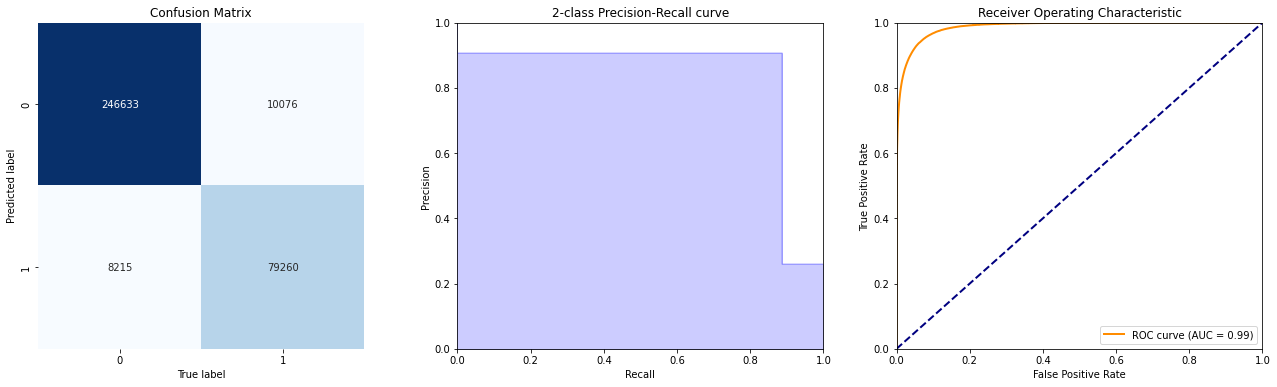

In [ ]:
y_rdm_train_pred = best_rdm_model.predict(X_rdm_train)
y_rdm_train_prob = best_rdm_model.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_rdm_train_pred, y_rdm_train_prob)

Accuracy : 0.8928 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7971 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7821 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9533                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


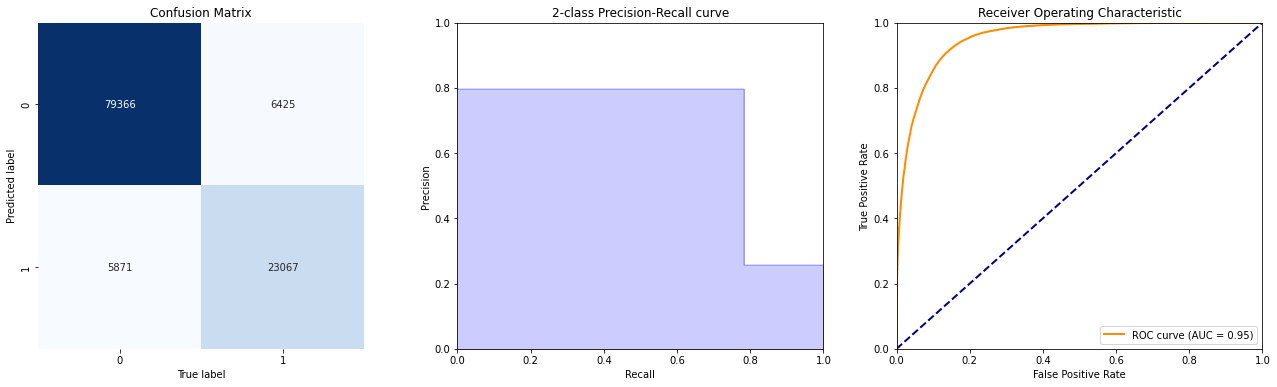

In [ ]:
y_rdm_test_pred = best_rdm_model.predict(X_rdm_test)
y_rdm_test_prob = best_rdm_model.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_rdm_test_pred, y_rdm_test_prob)

# Light gradient boosting machine/LGBM

best_random_lgbm_params = {'num_leaves': 150,
                            'max_detph': 11,
                            'min_data_in_leaf': 160,
                            #'n_estimators': n_estimators,
                            'learning_rates': 0.05,
                            'lambda_l1': 20,
                            'lambda_l2': 0,
                            'bagging_fraction':0.9,
                            'bagging_freq': 1,
                            'feature_fraction': 0.5                           
               }

Train:
Accuracy : 0.9126 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8314 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8320 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9670

Test
Accuracy : 0.8983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8016 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8029 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9574

In [ ]:
best_random_lgbm_params = {'num_leaves': 150,
                            'max_detph': 11,
                            'min_data_in_leaf': 160,
                            #'n_estimators': n_estimators,
                            'learning_rates': 0.05,
                            'lambda_l1': 20,
                            'lambda_l2': 0,
                            'bagging_fraction':0.9,
                            'bagging_freq': 1,
                            'feature_fraction': 0.5                           
               }

In [ ]:
best_lgbm_model = lgb.LGBMClassifier()
best_lgbm_model.set_params(**best_random_lgbm_params)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.5,
               lambda_l1=20, lambda_l2=0, learning_rates=0.05, max_detph=11,
               min_data_in_leaf=160, num_leaves=150)

In [ ]:
best_lgbm_model.fit(X_rdm_train, y_rdm_train)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, feature_fraction=0.5,
               lambda_l1=20, lambda_l2=0, learning_rates=0.05, max_detph=11,
               min_data_in_leaf=160, num_leaves=150)

Accuracy : 0.9126 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8314 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8320 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9670                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


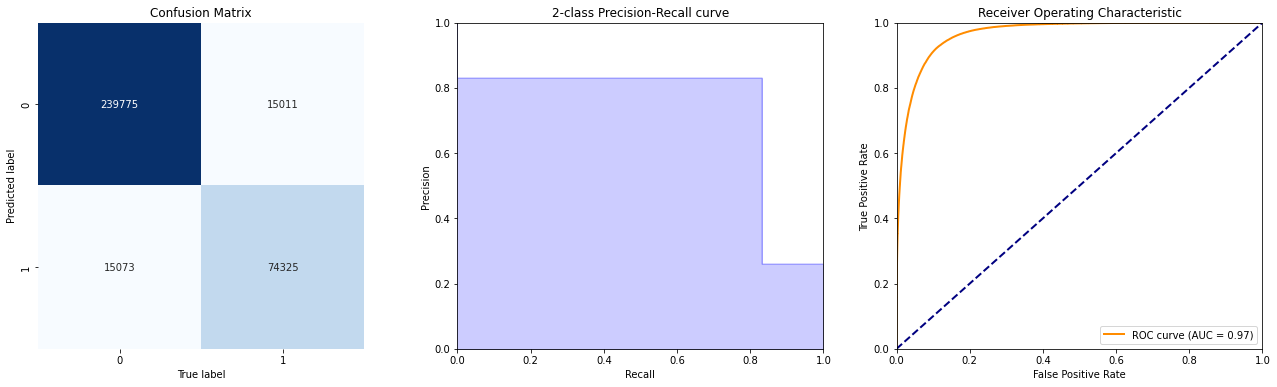

In [ ]:
y_lgbm_train_pred = best_lgbm_model.predict(X_rdm_train)
y_lgbm_train_prob = best_lgbm_model.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_lgbm_train_pred, y_lgbm_train_prob)

Accuracy : 0.8983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8016 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8029 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9574                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


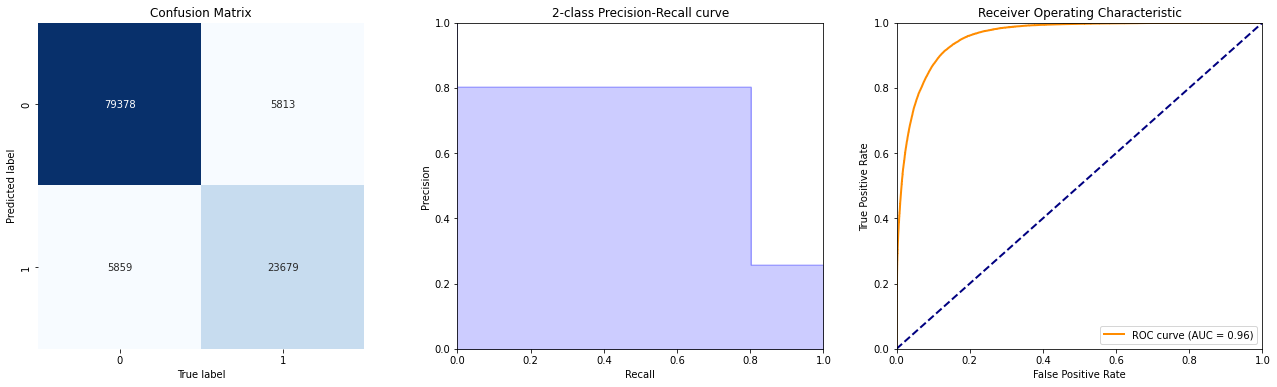

In [ ]:
y_lgbm_test_pred = best_lgbm_model.predict(X_rdm_test)
y_lgbm_test_prod = best_lgbm_model.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_lgbm_test_pred, y_lgbm_test_prod)

In [ ]:
yhat_pp_lgbm = best_lgbm_model.predict_proba(X_rdm_test)
yhat_pp_lgbm 

array([[0.95654807, 0.04345193],
       [0.40238007, 0.59761993],
       [0.9177984 , 0.0822016 ],
       ...,
       [0.99866089, 0.00133911],
       [0.07936045, 0.92063955],
       [0.99640092, 0.00359908]])

# Logistic Regression

In [ ]:
# according to 'Amex_kaggle_models_LogisticRegression_MiniProject2' best parameter result

In [ ]:
best_lr_params = {'C': 0.1, 'penalty': 'l2',
                                        'solver': 'newton-cg'}


In [ ]:
#best_lr_params = lr_rgrid_model_search.best_params_

In [ ]:
best_lr_model = LogisticRegression()
best_lr_model.set_params(**best_lr_params)

LogisticRegression(C=0.1, solver='newton-cg')

In [ ]:
best_lr_model.fit(X_rdm_train, y_rdm_train)

LogisticRegression(C=0.1, solver='newton-cg')

Accuracy : 0.8952 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8127 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7749 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9547                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


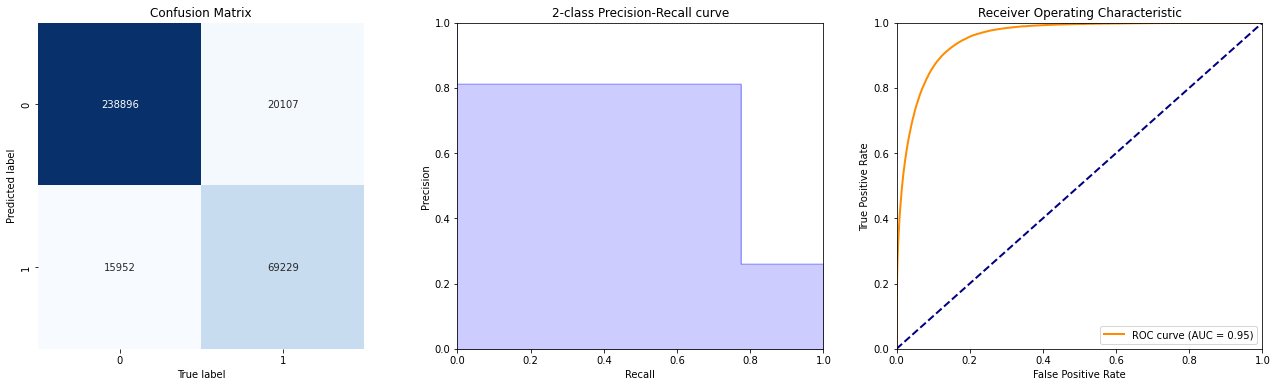

In [ ]:
y_lr_train_pred = best_lr_model.predict(X_rdm_train)
y_lr_train_prob = best_lr_model.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_lr_train_pred, y_lr_train_prob)

Accuracy : 0.8945 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8093 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7715 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9535                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


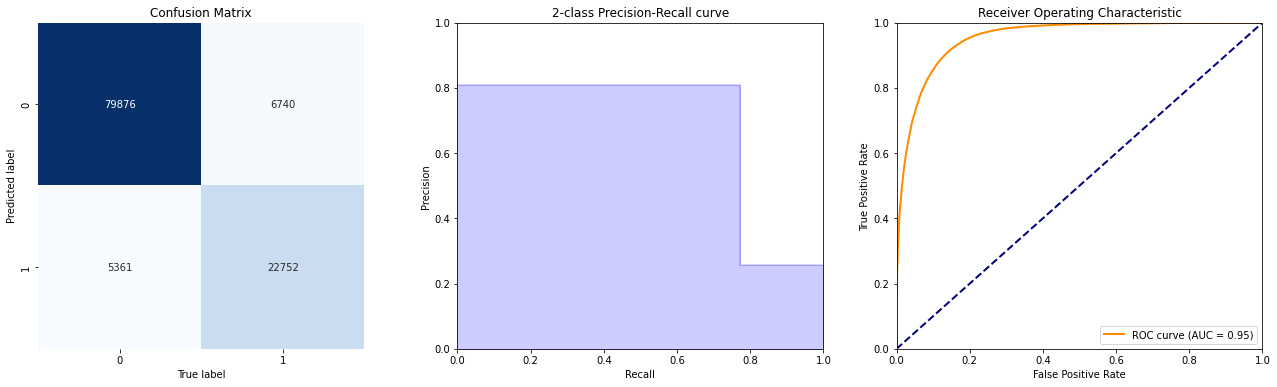

In [ ]:
y_lr_test_pred = best_lr_model.predict(X_rdm_test)
y_lr_test_prob = best_lr_model.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_lr_test_pred, y_lr_test_prob)

# Gaussian Naive Bayes

In [ ]:
best_random_nb_params = {'var_smoothing': 1e-05}

In [ ]:
best_nb_model = GaussianNB()
best_nb_model.set_params(**best_random_nb_params)

GaussianNB(var_smoothing=1e-05)

In [ ]:
best_nb_model.fit(X_rdm_train, y_rdm_train)

GaussianNB(var_smoothing=1e-05)

Accuracy : 0.8269 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7591 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4880 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8973                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


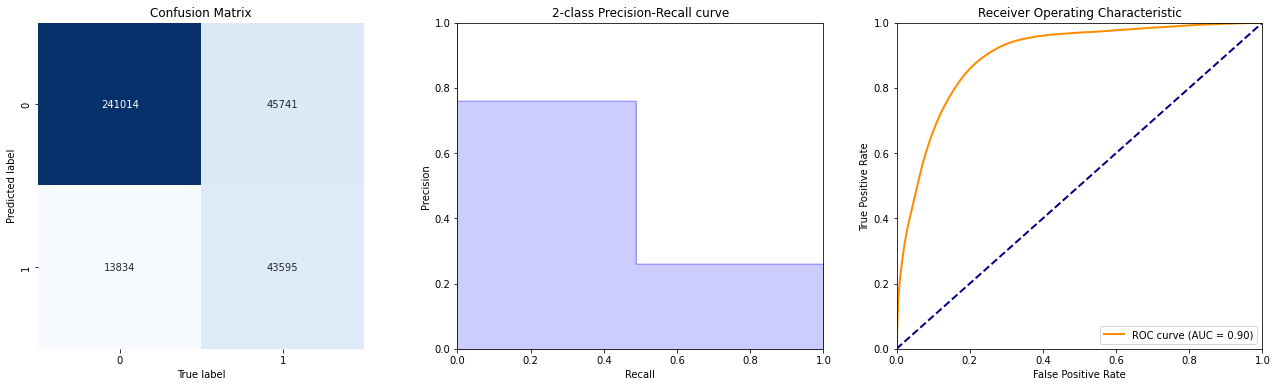

In [ ]:
y_nb_train_pred = best_nb_model.predict(X_rdm_train)
y_nb_train_prob = best_nb_model.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_nb_train_pred, y_nb_train_prob)

Accuracy : 0.8275 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7548 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4870 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8963                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


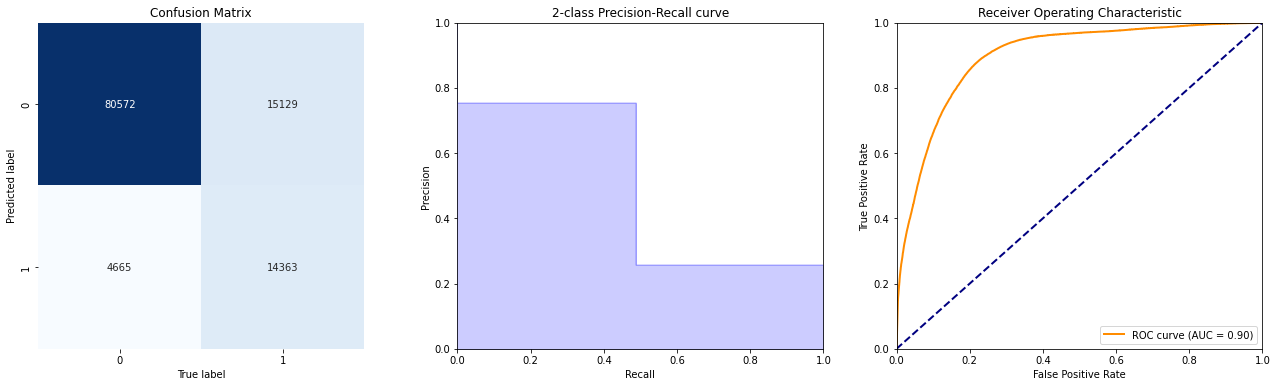

In [ ]:
y_nb_test_pred = best_nb_model.predict(X_rdm_test)
y_nb_test_prob = best_nb_model.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_nb_test_pred, y_nb_test_prob)

# Stacking

In [ ]:
#create sub models
stk_rdmf = best_rdm_model   
stk_lgbm = best_lgbm_model
stk_lr = best_lr_model
stk_gnb = best_nb_model
lr  = LogisticRegression ( multi_class= 'auto', solver = 'lbfgs')

# create ensemble model
stk_model_1 = StackingClassifier(classifiers = [stk_lr, stk_lgbm, stk_gnb], meta_classifier = lr)   # include LR,  LG+LGBM+GNB
stk_model_1.fit(X_rdm_train,  y_rdm_train)

stk_model_2 = StackingClassifier(classifiers = [stk_lr, stk_gnb], meta_classifier = lr)   # include LR, LR+GNB
stk_model_2.fit(X_rdm_train,  y_rdm_train)

stk_model_3 = StackingClassifier(classifiers = [stk_lr,stk_rdmf,stk_gnb], meta_classifier = lr)   # include LR, LR+GNB+RDMF
stk_model_3.fit(X_rdm_train,  y_rdm_train)

stk_model_4 = StackingClassifier(classifiers = [stk_lgbm,stk_rdmf, stk_gnb], meta_classifier = lr)   # NOT include LR, LGBM+GNB+RDMF
stk_model_4.fit(X_rdm_train,  y_rdm_train)

stk_model_5 = StackingClassifier(classifiers = [stk_lr,stk_rdmf,stk_gnb,stk_lgbm], meta_classifier = lr)   # include LR, LR+GNB+RDMF+LGBM
stk_model_5.fit(X_rdm_train,  y_rdm_train)

StackingClassifier(classifiers=[LogisticRegression(C=0.1, solver='newton-cg'),
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=22,
                                                       min_samples_leaf=16,
                                                       min_samples_split=14),
                                GaussianNB(var_smoothing=1e-05),
                                LGBMClassifier(bagging_fraction=0.9,
                                               bagging_freq=1,
                                               feature_fraction=0.5,
                                               lambda_l1=20, lambda_l2=0,
                                               learning_rates=0.05,
                                               max_detph=11,
                                               min_data_in_leaf=160,
                                               num_leaves=150)],
                   meta

In [ ]:
stk_model_1.score(X_rdm_test, y_rdm_test)

0.8982646061588613

In [ ]:
stk_model_2.score(X_rdm_test, y_rdm_test)

0.8945253597608277

In [ ]:
stk_model_3.score(X_rdm_test, y_rdm_test)

0.8926165136974958

In [ ]:
stk_model_4.score(X_rdm_test, y_rdm_test)

0.8930000261485762

Accuracy : 0.9126 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8314 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8320 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9044                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


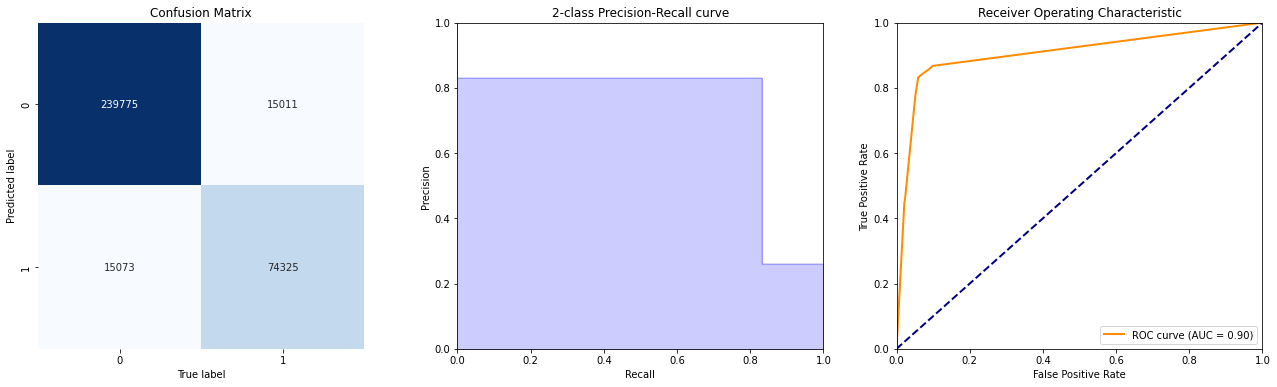

In [ ]:
y_stk1_train_pred = stk_model_1.predict(X_rdm_train)
y_stk1_train_prob = stk_model_1.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_stk1_train_pred, y_stk1_train_prob)

Accuracy : 0.8983 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8016 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8029 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8925                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


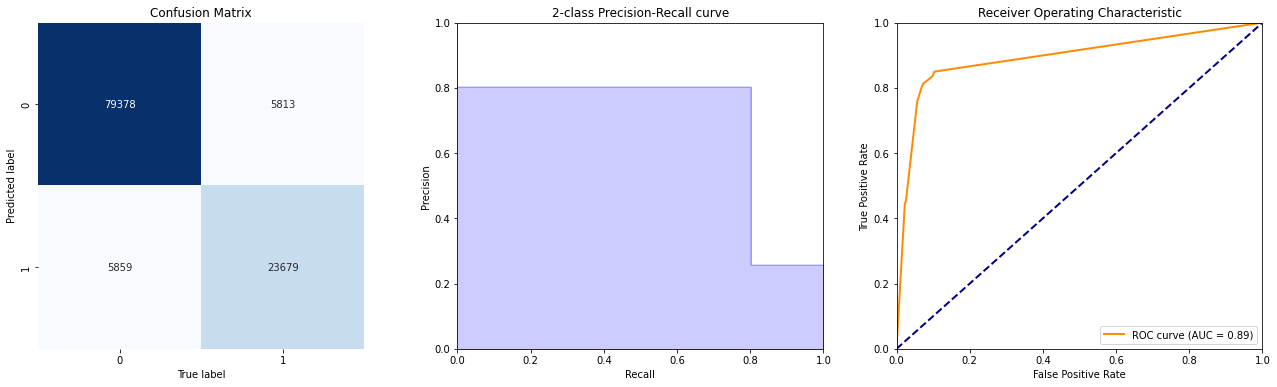

In [ ]:
y_stk1_test_pred = stk_model_1.predict(X_rdm_test)
y_stk1_test_prob =stk_model_1.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_stk1_test_pred, y_stk1_test_prob)

Accuracy : 0.8952 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8127 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7749 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8738                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


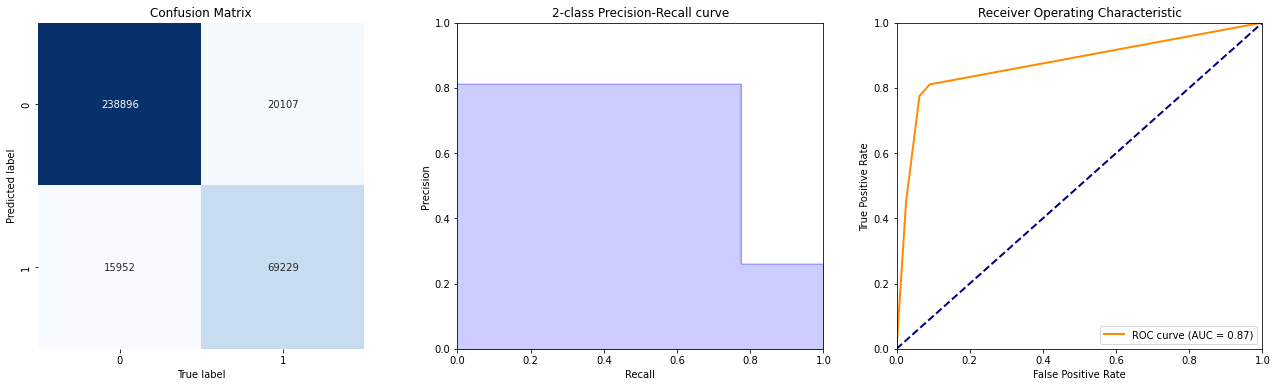

In [ ]:
y_stk2_train_pred = stk_model_2.predict(X_rdm_train)
y_stk2_train_prob = stk_model_2.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_stk2_train_pred, y_stk2_train_prob)

Accuracy : 0.8945 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8093 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7715 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8712                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


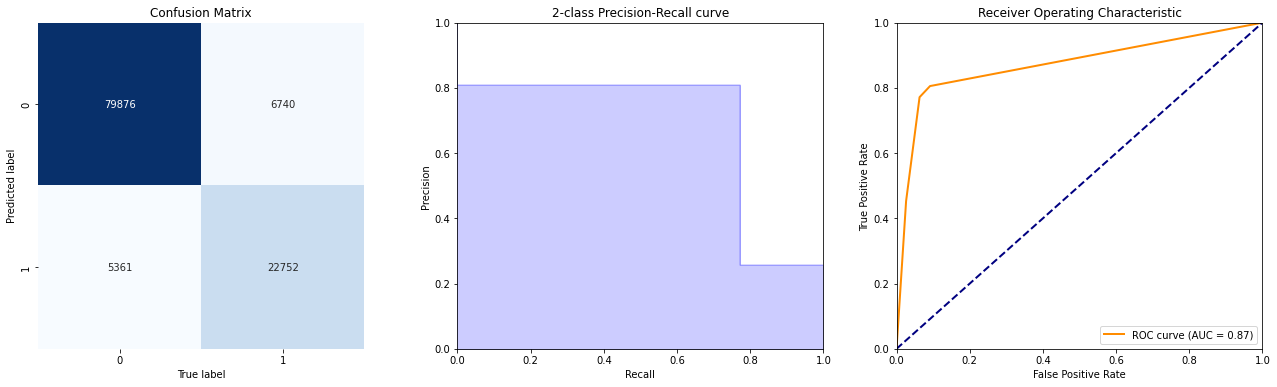

In [ ]:
y_stk2_test_pred = stk_model_2.predict(X_rdm_test)
y_stk2_test_prob =stk_model_2.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_stk2_test_pred, y_stk2_test_prob)

Accuracy : 0.9470 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9064 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8875 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9326                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


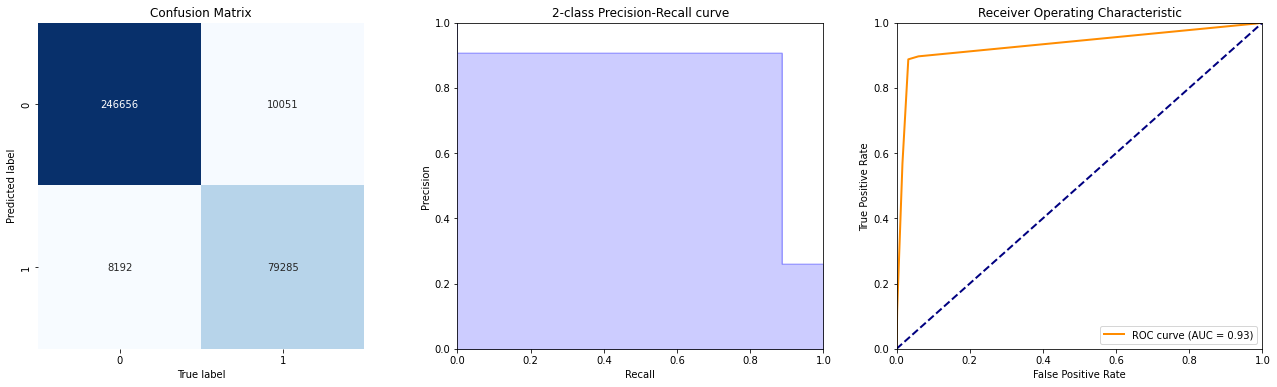

In [ ]:
y_stk3_train_pred = stk_model_3.predict(X_rdm_train)
y_stk3_train_prob = stk_model_3.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_stk3_train_pred, y_stk3_train_prob)

Accuracy : 0.8926 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7961 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7828 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8481                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


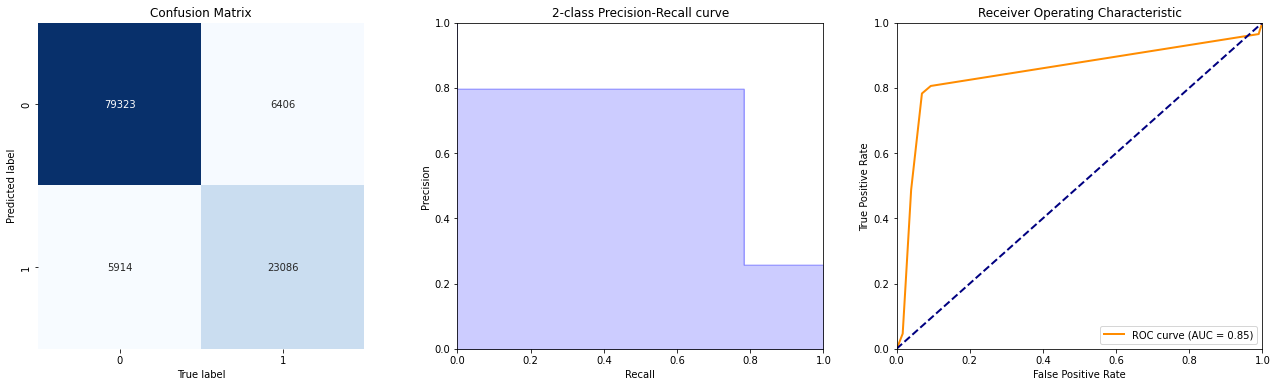

In [ ]:
y_stk3_test_pred = stk_model_3.predict(X_rdm_test)
y_stk3_test_prob =stk_model_3.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_stk3_test_pred, y_stk3_test_prob)

Accuracy : 0.9469 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9058 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8876 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9334                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


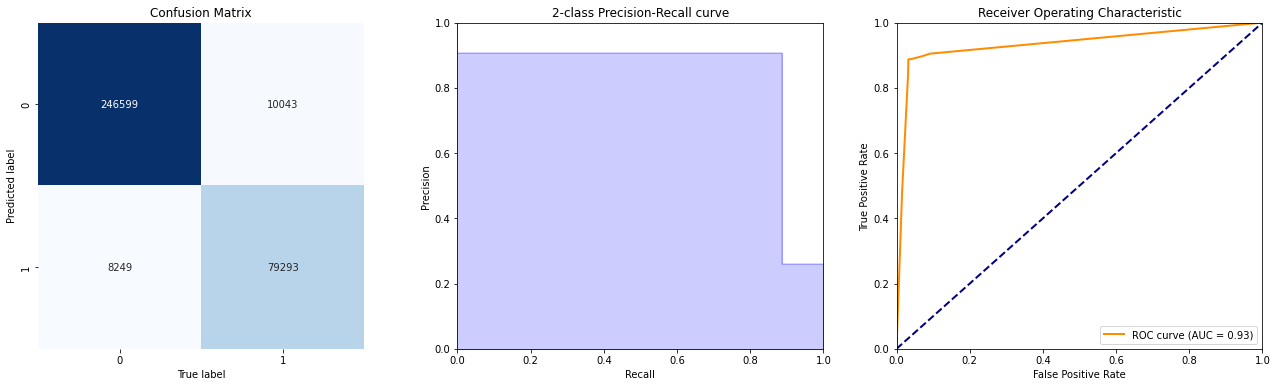

In [ ]:
y_stk4_train_pred = stk_model_4.predict(X_rdm_train)
y_stk4_train_prob = stk_model_4.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_stk4_train_pred, y_stk4_train_prob)

Accuracy : 0.8930 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7972 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7829 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8916                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


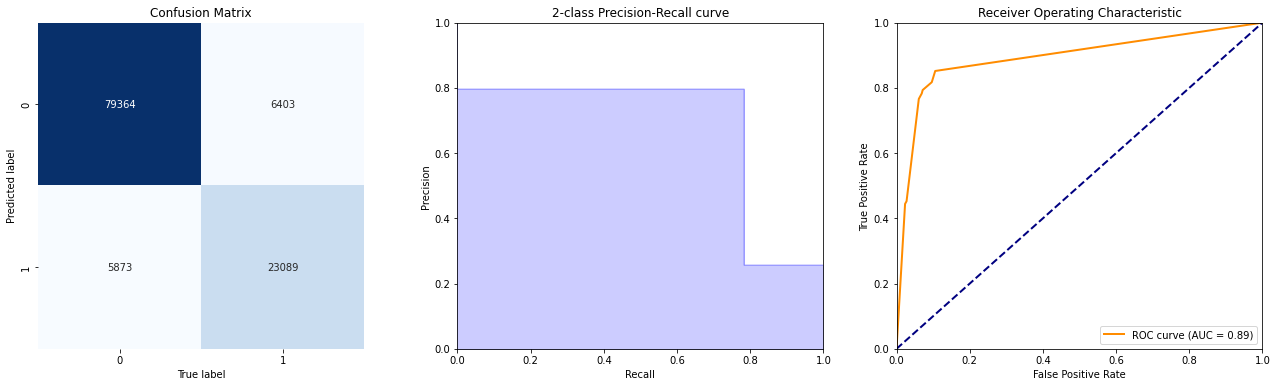

In [ ]:
y_stk4_test_pred = stk_model_4.predict(X_rdm_test)
y_stk4_test_prob =stk_model_4.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_stk4_test_pred, y_stk4_test_prob)

Accuracy : 0.9470 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9067 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8872 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.9341                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


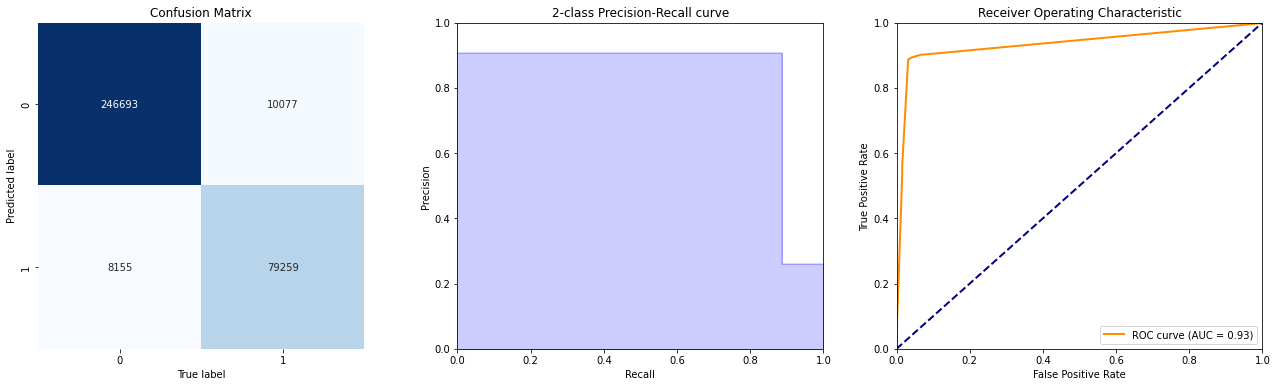

In [ ]:
y_stk5_train_pred = stk_model_5.predict(X_rdm_train)
y_stk5_train_prob = stk_model_5.predict_proba(X_rdm_train)
show_summary_report(y_rdm_train, y_stk5_train_pred, y_stk5_train_prob)

Accuracy : 0.8932 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7978 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7831 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8666                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


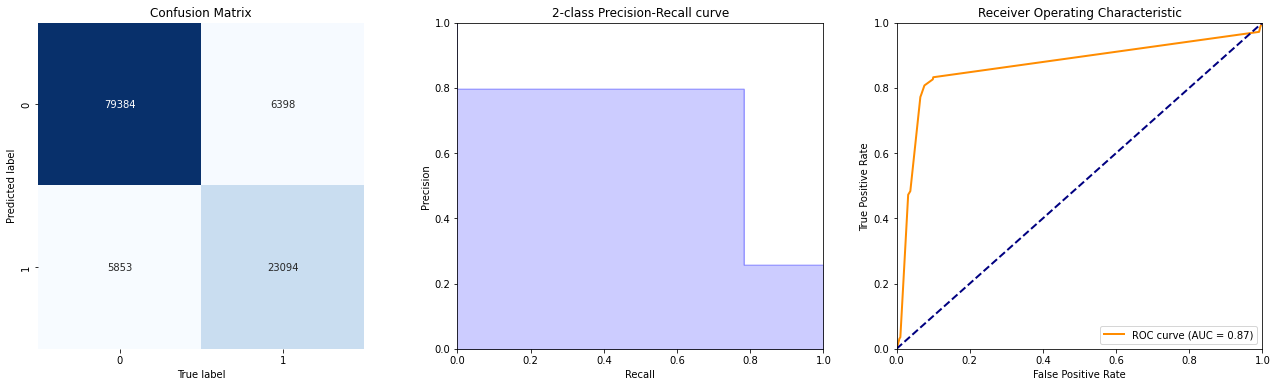

In [ ]:
y_stk5_test_pred = stk_model_5.predict(X_rdm_test)
y_stk5_test_prob =stk_model_5.predict_proba(X_rdm_test)
show_summary_report(y_rdm_test, y_stk5_test_pred, y_stk5_test_prob)

# Evaluation

In [ ]:
yhat_pp_rdm = best_rdm_model.predict_proba(X_rdm_test)
yhat_pp_lgbm = best_lgbm_model.predict_proba(X_rdm_test)
yhat_pp_gnb = best_nb_model.predict_proba(X_rdm_test)
yhat_pp_lr = best_lr_model.predict_proba(X_rdm_test)
yhat_pp_stk1 = stk_model_1.predict_proba(X_rdm_test)
yhat_pp_stk2 = stk_model_2.predict_proba(X_rdm_test)
yhat_pp_stk3 = stk_model_3.predict_proba(X_rdm_test)
yhat_pp_stk4 = stk_model_4.predict_proba(X_rdm_test)
yhat_pp_stk5 = stk_model_5.predict_proba(X_rdm_test)

In [ ]:
fpr_rdm, tpr_rdm, _ = roc_curve(y_rdm_test, yhat_pp_rdm[:,1])
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_rdm_test, yhat_pp_lgbm[:,1])
fpr_gnb, tpr_gnb, _ = roc_curve(y_rdm_test, yhat_pp_gnb[:,1])
fpr_lr, tpr_lr, _ = roc_curve(y_rdm_test, yhat_pp_lr[:,1])
fpr_stk1, tpr_stk1, _ = roc_curve(y_rdm_test, yhat_pp_stk1[:,1])
fpr_stk2, tpr_stk2, _ = roc_curve(y_rdm_test, yhat_pp_stk2[:,1])
fpr_stk3, tpr_stk3, _ = roc_curve(y_rdm_test, yhat_pp_stk3[:,1])
fpr_stk4, tpr_stk4, _ = roc_curve(y_rdm_test, yhat_pp_stk4[:,1])
fpr_stk5, tpr_stk5, _ = roc_curve(y_rdm_test, yhat_pp_stk5[:,1])

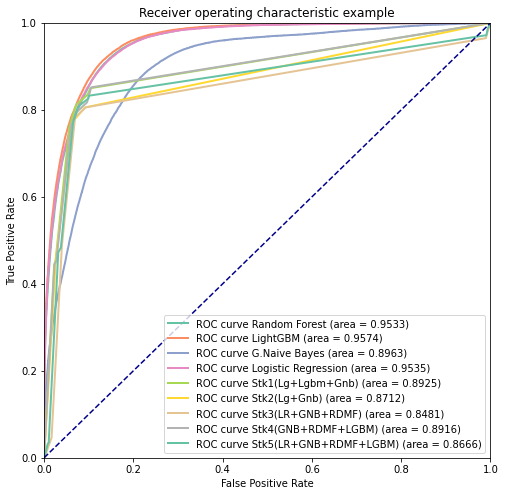

In [ ]:
plt.figure(figsize=[8,8])
line_width = 2    # lw is line width
plt.plot(fpr_rdm, tpr_rdm, label='ROC curve Random Forest (area = %0.4f)' % auc(fpr_rdm, tpr_rdm), linewidth= line_width)
plt.plot(fpr_lgbm, tpr_lgbm, label='ROC curve LightGBM (area = %0.4f)' % auc(fpr_lgbm, tpr_lgbm), linewidth= line_width)
plt.plot(fpr_gnb, tpr_gnb, label='ROC curve G.Naive Bayes (area = %0.4f)' % auc(fpr_gnb, tpr_gnb), linewidth= line_width)
plt.plot(fpr_lr, tpr_lr, label='ROC curve Logistic Regression (area = %0.4f)' % auc(fpr_lr, tpr_lr), linewidth= line_width)
plt.plot(fpr_stk1, tpr_stk1, label='ROC curve Stk1(Lg+Lgbm+Gnb) (area = %0.4f)' % auc(fpr_stk1, tpr_stk1), linewidth= line_width)
plt.plot(fpr_stk2, tpr_stk2, label='ROC curve Stk2(Lg+Gnb) (area = %0.4f)' % auc(fpr_stk2, tpr_stk2), linewidth= line_width)
plt.plot(fpr_stk3, tpr_stk3, label='ROC curve Stk3(LR+GNB+RDMF) (area = %0.4f)' % auc(fpr_stk3, tpr_stk3), linewidth= line_width)
plt.plot(fpr_stk4, tpr_stk4, label='ROC curve Stk4(GNB+RDMF+LGBM) (area = %0.4f)' % auc(fpr_stk4, tpr_stk4), linewidth= line_width)
plt.plot(fpr_stk5, tpr_stk5, label='ROC curve Stk5(LR+GNB+RDMF+LGBM) (area = %0.4f)' % auc(fpr_stk5, tpr_stk5), linewidth= line_width)
plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

In [ ]:
roc_auc_score(y_rdm_test, yhat_pp_lgbm[:,1])

0.957413697588849

In [ ]:
acc_lgbm = accuracy_score(y_rdm_test, y_lgbm_test_pred)
prec_lgbm = precision_score(y_rdm_test, y_lgbm_test_pred)
recll_lgbm = recall_score(y_rdm_test, y_lgbm_test_pred)
rocauc_lgbm = recall_score(y_rdm_test, y_lgbm_test_pred)
auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

acc_gnb = accuracy_score(y_rdm_test, y_nb_test_pred)
prec_gnb = precision_score(y_rdm_test, y_nb_test_pred)
recll_gnb = recall_score(y_rdm_test, y_nb_test_pred)
rocauc_gnb = recall_score(y_rdm_test, y_nb_test_pred)
auc_gnb = auc(fpr_gnb, tpr_gnb)

acc_lr = accuracy_score(y_rdm_test, y_lr_test_pred)
prec_lr = precision_score(y_rdm_test, y_lr_test_pred)
recll_lr = recall_score(y_rdm_test, y_lr_test_pred)
rocauc_lr = recall_score(y_rdm_test, y_lr_test_pred)
auc_lr = auc(fpr_lr, tpr_lr)

acc_stk1 = accuracy_score(y_rdm_test, y_stk1_test_pred)
prec_stk1 = precision_score(y_rdm_test, y_stk1_test_pred)
recll_stk1 = recall_score(y_rdm_test, y_stk1_test_pred)
rocauc_stk1 = recall_score(y_rdm_test, y_stk1_test_pred)
auc_stk1 = auc(fpr_stk1, tpr_stk1)

acc_stk2 = accuracy_score(y_rdm_test, y_stk2_test_pred)
prec_stk2 = precision_score(y_rdm_test, y_stk2_test_pred)
recll_stk2 = recall_score(y_rdm_test, y_stk2_test_pred)
rocauc_stk2 = recall_score(y_rdm_test, y_stk2_test_pred)
auc_stk2 = auc(fpr_stk2, tpr_stk2)

acc_stk3 = accuracy_score(y_rdm_test, y_stk3_test_pred)
prec_stk3 = precision_score(y_rdm_test, y_stk3_test_pred)
recll_stk3 = recall_score(y_rdm_test, y_stk3_test_pred)
rocauc_stk3 = recall_score(y_rdm_test, y_stk3_test_pred)
auc_stk3 = auc(fpr_stk3, tpr_stk3)

acc_stk4 = accuracy_score(y_rdm_test, y_stk4_test_pred)
prec_stk4 = precision_score(y_rdm_test, y_stk4_test_pred)
recll_stk4 = recall_score(y_rdm_test, y_stk4_test_pred)
rocauc_stk4 = recall_score(y_rdm_test, y_stk4_test_pred)
auc_stk4 = auc(fpr_stk4, tpr_stk4)

acc_stk5 = accuracy_score(y_rdm_test, y_stk5_test_pred)
prec_stk5 = precision_score(y_rdm_test, y_stk5_test_pred)
recll_stk5 = recall_score(y_rdm_test, y_stk5_test_pred)
rocauc_stk5 = recall_score(y_rdm_test, y_stk5_test_pred)
auc_stk5 = auc(fpr_stk5, tpr_stk5)

In [ ]:
auc(fpr_lgbm, tpr_lgbm)

0.957413697588849

In [ ]:
# accuracy indicate what proportions of Positive and Negative are correclty classified? 
# precision indicate what proportion of Predicted Positives is truly Positive? =  what proportion of predicted default is truly default? 
# recall indicate what proportion of Actual Positives is correctly classified?  = what proportion of Actual defaul is correctly classified ? this is important for fiancial service company
# AUC/Area under the curve: measure of the ability of classifier to distinguish between classes


In [ ]:
model_comparision_df = pd.DataFrame({"Accuracy":[acc_lgbm,acc_gnb,acc_lr,acc_stk1, acc_stk2,acc_stk3,acc_stk4,acc_stk5 ],
                                     "Precision":[prec_lgbm, prec_gnb, prec_lr, prec_stk1, prec_stk2,prec_stk3, prec_stk4, prec_stk5],
                                     "Recall": [recll_lgbm, recll_gnb, recll_lr, recll_stk1, recll_stk2, recll_stk3, recll_stk4, recll_stk5],
                                     "AUC": [auc_lgbm, auc_gnb, auc_lr, auc_stk1, auc_stk2, auc_stk3, auc_stk4, auc_stk5],
                                    "Model Name":["Light GBM","Naive Bayes","Logistic Regression",
                                             "Stk1(Lg+Lgbm+Gnb)","Stk2(Lg+Gnb)", "Stk3(LR+GNB+RDMF)", "Stk4(GNB+RDMF+LGBM)",  "Stk5(LR+GNB+RDMF+LGBM)"]},columns = ["Model Name","Accuracy","Precision", "Recall", "AUC"])
model_comparision_df.sort_values(by="Recall",ascending = False)
model_comparision_df
# something not right

,Model Name,Accuracy,Precision,Recall,AUC
0,Light GBM,0.898265,0.801645,0.802896,0.957414
1,Naive Bayes,0.827472,0.754835,0.487013,0.896297
2,Logistic Regression,0.894525,0.809305,0.771463,0.953480
3,Stk1(Lg+Lgbm+Gnb),0.898265,0.801645,0.802896,0.892527
4,Stk2(Lg+Gnb),0.894525,0.809305,0.771463,0.871155
5,Stk3(LR+GNB+RDMF),0.892617,0.796069,0.782789,0.848071
6,Stk4(GNB+RDMF+LGBM),0.893000,0.797217,0.782890,0.891552
7,Stk5(LR+GNB+RDMF+LGBM),0.893218,0.797803,0.783060,0.866617


# Prediction submission

In [ ]:
rdm_features = [c for c in rdm_train.columns if c not in ['customer_ID', 'target']]
submission_rdm_test = data_test[rdm_features ]
submission_rdm_test 

In [ ]:
y_rdm_pred_submission = stk_model_5.predict(submission_rdm_test )

In [ ]:
y_rdm_pred_submission.shape

In [ ]:
y_rdm_pred_submission[:10]

In [ ]:
data_test = data_test.reset_index()

In [ ]:
data_submission =  pd.DataFrame({'customer_ID': data_test.customer_ID, 'prediction':y_rdm_pred_submission })
data_submission.set_index('customer_ID', inplace = True)
data_submission.head(3)

In [ ]:
path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition'
data_submission.to_csv(path+ '/submission_220822_miniproject2_stk_5.csv')